# TUTORIAL: Real-time data assimilation
<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.4/MathJax.js?config=default'></script>

* [What is real-time data assimilation?](#first)
    * [Real-time assimilation cycle](#cycle)
    * [Sources of uncertainties in the assimilation framework](#second)
    * [Bayesian formulation of data assimilation](#fourth)
    * [Example of Bayesian update in an univariate case](#fourth-1)
* [Stochastic ensemble framework: the Ensemble Kalman filter](#fifth)
    * [Augmented state-space formulation](#third)
    * [Ensemble statistics](#ens)
* [Test case: twin experiment on a Van der Pol oscillator](#fifth-vdp)
    * [What is a twin experiment?](#fifth-twin)
    * [The Van der Pol system](#vdp)


# 1. What is Real-Time Data Assimilation? <a name="first"></a>

Data assimilation is a technique for combining observational data and numerical models to improve our understanding and prediction of complex physical systems. It enables more accurate forecasts and decision-making across fields such as meteorology, hydrology, and oceanography. The overarching objective is to make *qualitatively* accurate numerical models more *quantitatively* correct.

The three main components of data assimilation are: a model of the physical system, observation data from sensors, and a statistical method, which integrates the data with the model to estimate the most likely system behavior. There are various statistical approaches to data assimilation, broadly classified into
- **Variational methods** (e.g., 4DVar), which assimlate all the data in one shot a posteriori. 
- **Sequential methods** (e.g., Kalman filters), which assimilate the sensors' measurement as they become availe, i.e., without the need to store and post-process the data. Therefore, sequential methods are often referred to as **real-time data assimilation**. This iterative procedure continuously collects data and updates model states and/or parameters accordingly.

Real-time data assimilation aims to estimate a physical quantity $\mathbf{d}^\dagger$ (i.e., the *truth*), which is unknown, by combining two sources of information:



## 1.1 Sources of Information and Uncertainty in the Assimilation Framework <a name="second"></a>

1. **Observational data** $\mathbf{d}$

These represent real-world measurements of observable quantities. The sensors are assumed to be **unbiased** but subject to **aleatoric uncertainty** (e.g., environmental or instrumental noise):

$$
\mathbb{E}[\mathbf{d}] = \mathbf{d}^\dagger, \quad \mathbf{d} \sim \mathcal{N}(\mathbf{d}^\dagger, \mathbf{C}_{dd}),
$$

where $\mathbf{C}_{dd}$ is a diagonal covariance matrix representing measurement errors.



2. **A physical numerical model** 

The model provides estimates of the system's internal state through a dynamical system

   $$
   \begin{aligned}
   \mathrm{d}\boldsymbol{\phi} &= \mathcal{F}\left(\boldsymbol{\phi}, \boldsymbol{\alpha} \right)\mathrm{d} t 
   \end{aligned}
   $$

   where
   - $\boldsymbol{\phi}$: state variables  
   - $\boldsymbol{\alpha}$: model parameters  
   - $\mathcal{F}$: nonlinear dynamics operator

In many cases, observations are not direct measurements of the state vector. Instead, a **measurement operator** $\mathbf{M}$ maps the model state to the observable space. We assume the model is unbiased in its predictions such that

$$
\mathbb{E}[\mathcal{M}(\boldsymbol{\phi})] = \mathbf{d}^\dagger.
$$

In practice, several sources of **aleatoric uncertainty** arise in the assimilation process:

- In the **model dynamics** $\mathcal{F}$, due to uncertain states $\boldsymbol{\phi}$ or parameters $\boldsymbol{\alpha}$,
- In the **measurement process** $\mathcal{M}$, due to discretization or model inadequacy.

We represent these uncertainties as deviations from the true values

$$
\boldsymbol{\phi} + \boldsymbol{\epsilon}_\phi = \boldsymbol{\phi}^\dagger, \quad
\boldsymbol{\alpha} + \boldsymbol{\epsilon}_\alpha = \boldsymbol{\alpha}^\dagger, \quad
\mathbf{M}\boldsymbol{\phi} + \boldsymbol{\epsilon}_q = \mathbf{d}^\dagger.
$$

# 1.2. Bayesian formulation of data assimilation <a class="anchor" id="fourth"></a>

To find the *analysis* state, i.e., the state which best captures the evolution of the system given the model $\mathcal{F}$ and the noisy, partial observations $\mathbf{d}$, we formulate a well-posed Bayesian maximum *a posteriori* estimation problem. 

### Probabilistic Framework

First, the state $\boldsymbol{\phi}$ and observations $\mathbf{d}$ are assumed to be realizations of their corresponding random variables, so that we can quantify our confidence by a probability measure $\mathcal{P}$. Accounting for uncertainty, the model becomes
$$
\begin{aligned}
\mathrm{d} \boldsymbol{\phi} &= \mathcal{F}\left(\boldsymbol{\phi}+\boldsymbol{\epsilon}_\phi, \boldsymbol{\alpha} +\boldsymbol{\epsilon}_\alpha\right)\mathrm{d} t 
\end{aligned}
$$
And the observations at time $t_k$ are modeled as:

$$
\mathbf{d} + \boldsymbol{\epsilon}_d = \mathbf{d}^\dagger, \quad \boldsymbol{\epsilon}_d \sim \mathcal{N}(\mathbf{0}, \mathbf{C}_{dd})
$$

with
$
\mathbb{E}(\mathbf{d}) = \mathbf{d}^\dagger
$
In this tutorial, we will assume that the parameters of the system are know, hence the only task is to infer the states of the system given some observations. This is, state estimation. 


### Markovian Prior

Second, we assume the model is Markovian, such that our prior on the state $\boldsymbol{\phi}_k = \boldsymbol{\phi}(t_k)$ follows:

$$
\mathcal{P}(\boldsymbol{\phi}_k \mid \boldsymbol{\phi}_{k-1}, \mathbf{F}) = \mathcal{P}(\boldsymbol{\phi}(t_k) \mid \boldsymbol{\phi}(t_1), \dots, \boldsymbol{\phi}_{k-1}, \mathbf{F})
$$
where $\mathcal{P}(\cdot|\cdot)$ denotes the conditional probability in which the quantity on the left is conditioned on the knowledge of the quantities on the right.

### Bayesian Update

Third, we update our confidence in the model predictions every time we have reference data from observations in a real-time framework. This is, when new observations $\mathbf{d}_k$ are available, our *prior* can be updated using Bayes' rule
$$
\begin{align}
\mathcal{P}(\boldsymbol{\phi}_k | \mathbf{d}_k,\mathbf{F}) = \frac{\mathcal{P}(\mathbf{d}_k | \boldsymbol{\phi}_k,  \mathbf{F}) \mathcal{P}(\boldsymbol{\phi}_k, \mathbf{F})}{\mathcal{P}(\mathbf{d}_k,  \mathbf{F})}, \quad \text{i.e.,} \quad
\texttt{posterior} = \dfrac{\texttt{prior}
\,\times\,
\texttt{likelihood}}
{\texttt{evidence}} 
\end{align}
$$
where the likelihood of the observations measures how consistent the predicted state $\boldsymbol{\phi}_k$ is with the new observation $\mathbf{d}_k$. We select the most probable value  (the mode) of $\boldsymbol{\phi}_k$ in the posterior as the best estimator of the state, i.e., the analysis. This is the <em >maximum a posteriori </em>  approach, which is a well-posed approach in inverse problems.

### Gaussian assumption
We assume a Gaussian prior and likelihood, i.e.,

$$
\boldsymbol{\phi}^f \sim \mathcal{N}(\boldsymbol{\phi}, \mathbf{C}_{\phi\phi}^f), \quad \mathbf{d} \sim \mathcal{N}(\mathbf{M}\boldsymbol{\phi}, \mathbf{C}_{dd})
$$

where:
- $\mathbf{C}_{\phi\phi}^f$ and $\mathbf{C}_{dd}$ are the forecast and measurement error covariances, respectively,
- the superscript $f$ indicates 'forecast'. 

With these assumptions, the posterior will also be Gaussian.

### Maximum a Posteriori (MAP) Estimation

Taking a maximum a posteriori approach:

$$
\boldsymbol{\phi}^a = \underset{\boldsymbol{\phi}}{\text{argmax}}\, \mathcal{P}(\boldsymbol{\phi} \mid \mathbf{d}, \mathbf{F}) = \underset{\boldsymbol{\phi}}{\text{argmin}}\, \mathcal{J}(\boldsymbol{\phi})
$$

where the cost function to minimize is:

$$
\mathcal{J}(\boldsymbol{\phi}) = (\boldsymbol{\phi}^f - \boldsymbol{\phi})^\top (\mathbf{C}_{\phi\phi}^f)^{-1} (\boldsymbol{\phi}^f - \boldsymbol{\phi}) + (\mathbf{d} - \mathbf{M}\boldsymbol{\phi})^\top \mathbf{C}_{dd}^{-1} (\mathbf{d} - \mathbf{M}\boldsymbol{\phi})
$$



## 1.3. Example of Bayesian update in an univariate case

In [1]:
import numpy as np    
from scipy import stats, linalg
import matplotlib.pyplot as plt


x_grid = np.linspace(-10, 10, 101)

def pdf_Normal(mu, std):
    return stats.norm.pdf(x_grid, loc=mu, scale=std)
    
def Bayes_rule(prior, likelihood):
    posterior = prior * likelihood       
    return posterior / (np.sum(posterior) * (x_grid[1] - x_grid[0]))


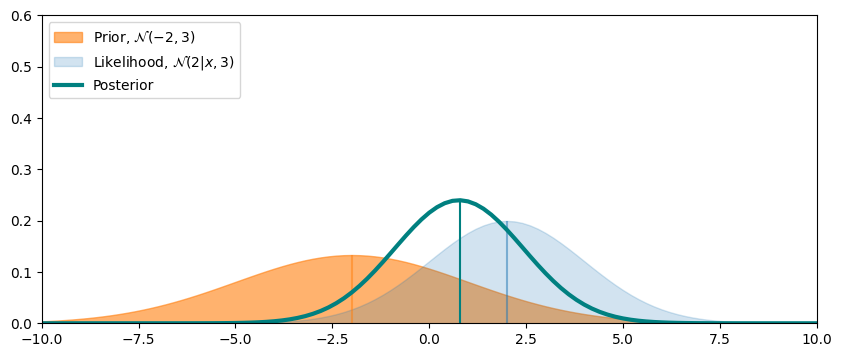

In [2]:
# Initialise prior
prior_mu, prior_std = -2, 3
prior_vals = pdf_Normal(mu=prior_mu, std=prior_std)

# Initialise likelihood
def likelihood_func(observation, method=pdf_Normal, likelihood_std=2):
    return method(mu=observation, std=likelihood_std)

# Observe a data point d and compute the posterior
d = 2
likelihood_vals = likelihood_func(observation=d)     

# Compute the new posterior
posterior_vals = Bayes_rule(prior_vals, likelihood_vals)

# Visualize

plt.figure(figsize=(10, 4))

plt.fill_between(x_grid, prior_vals,  color='tab:orange', alpha=0.6, label='Prior, $\mathcal{N}$'+f'$({prior_mu}, {prior_std})$')
plt.vlines(prior_mu,  ymin=0, ymax=np.max(prior_vals), color='tab:orange', alpha=0.5)

plt.fill_between(x_grid, likelihood_vals, color='tab:blue', alpha=0.2,  label='Likelihood, $\mathcal{N}$'+f'$({d}|x, {prior_std})$')
plt.vlines(d,  ymin=0, ymax=np.max(likelihood_vals), color='tab:blue', alpha=0.5)

plt.plot(x_grid, posterior_vals,  color='teal', lw=3 ,label='Posterior')
plt.vlines(x_grid[np.argmax(posterior_vals)], ymin=0, ymax=np.max(posterior_vals), color='teal')
plt.gca().set(ylim=(0, 0.6), xlim=(-10, 10))
plt.legend(loc="upper left");




<br />

___

#### Exercise
<em><font color=#7CB9E8>  What happens if the variance of the prior is small? What if the prior or likelihood functions are not Gaussian?
___



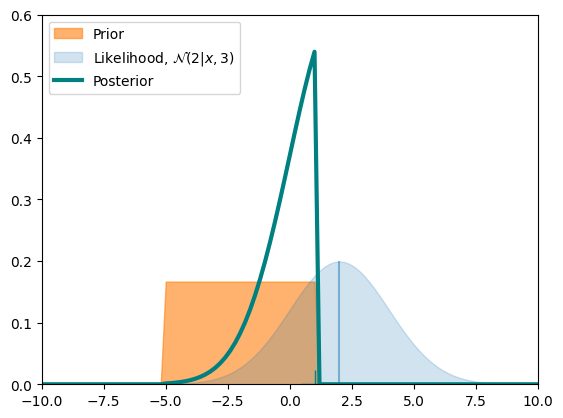

In [3]:
# prior_vals_2 = pdf_Normal(mu=prior_mu, std=prior_std) + pdf_Normal(mu=7, std=1)
prior_vals_2 = stats.uniform(loc=-5, scale=6).pdf(x_grid)

posterior_vals_2 = Bayes_rule(prior_vals_2, likelihood_vals)

# Visualize
plt.fill_between(x_grid, prior_vals_2,  color='tab:orange', alpha=0.6, label='Prior')
plt.fill_between(x_grid, likelihood_vals, color='tab:blue', alpha=0.2,  label='Likelihood, $\mathcal{N}$'+f'$({d}|x, {prior_std})$')
plt.vlines(d,  ymin=0, ymax=np.max(likelihood_vals), color='tab:blue', alpha=0.5)
plt.plot(x_grid, posterior_vals_2,  color='teal', lw=3 ,label='Posterior')
plt.plot(x_grid[np.argmax(posterior_vals_2)], 0, '+', markersize=20, color='teal')
plt.gca().set(ylim=(0, 0.6), xlim=(-10, 10))
plt.legend(loc="upper left");

### Sequential update
In real-time data assimilation, we perform this update sequentially, using the posterior as the new prior:

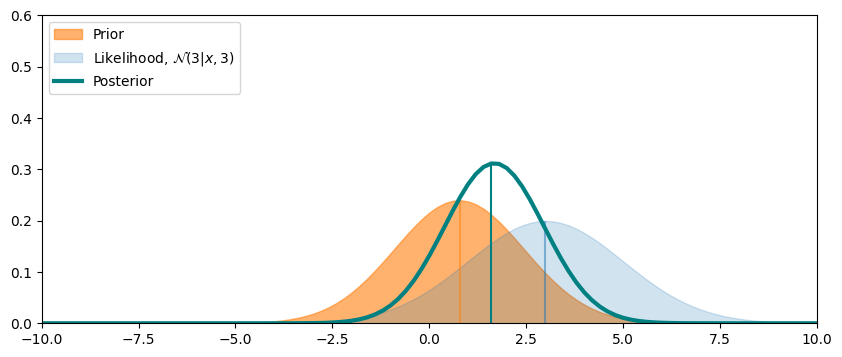

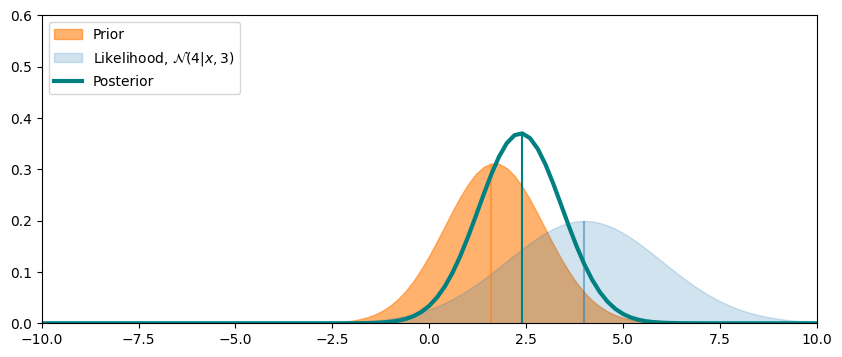

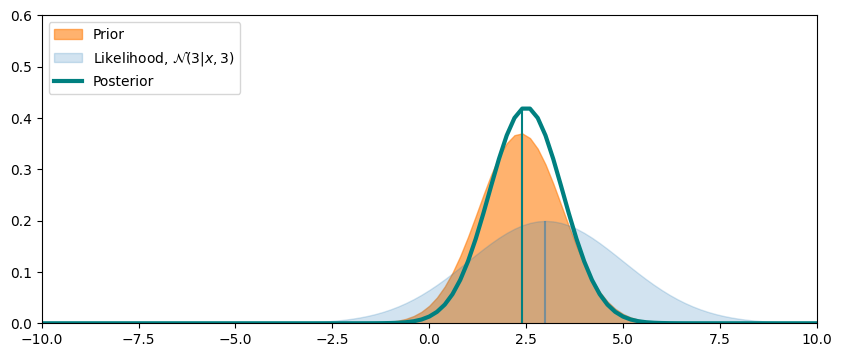

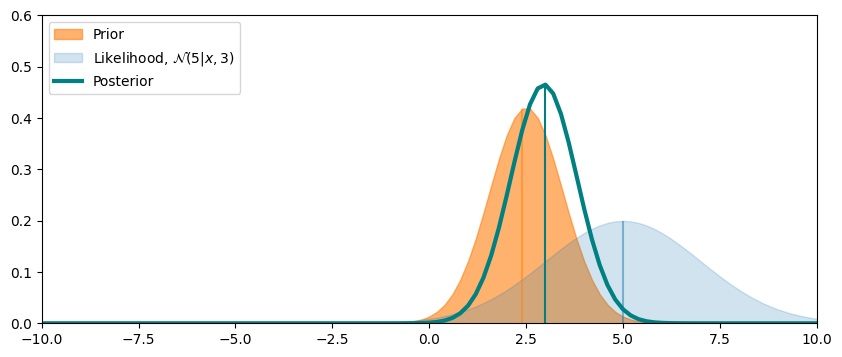

In [4]:
observation_stream = [3,4,3,5]
for d in observation_stream:
    
    prior_vals = posterior_vals                                 # Use the posterior as the new prior
    likelihood_vals = likelihood_func(observation=d)            # Compute the likelihood od the observation
    posterior_vals = Bayes_rule(prior_vals, likelihood_vals)    # Compute the new posterior
    
    plt.figure(figsize=(10, 4))
    plt.fill_between(x_grid, prior_vals,  color='tab:orange', alpha=0.6, label='Prior') # Use the posterior as the new prior
    plt.vlines(x_grid[np.argmax(prior_vals)],  ymin=0, ymax=np.max(prior_vals), color='tab:orange', alpha=0.5)
    plt.fill_between(x_grid, likelihood_vals, color='tab:blue', alpha=0.2,  label='Likelihood, $\mathcal{N}$'+f'$({d}|x, {prior_std})$')
    plt.vlines(d,  ymin=0, ymax=np.max(likelihood_vals), color='tab:blue', alpha=0.5)
    plt.plot(x_grid, posterior_vals,  color='teal', lw=3,label='Posterior')
    plt.vlines(x_grid[np.argmax(posterior_vals)],  ymin=0, ymax=np.max(posterior_vals), color='teal')
    plt.gca().set(ylim=(0, 0.6), xlim=(-10, 10))
    plt.legend(loc="upper left");




<br />

___


####  Exercise
<em> <font color=#7CB9E8> <em>
Given Gaussian prior $\boldsymbol{\phi} \sim \mathcal{N}(\boldsymbol{\phi}, \mathbf{C}_{\phi\phi})$ and a likelihood $
\mathbf{d}|\boldsymbol{\phi}) \sim \mathcal{N}(\mathbf{d}, \mathbf{C}_{dd})$,  show that the posterior is also a Gaussian. Hint: the  probability density function of a Gaussian distribution of mean $\boldsymbol{\mu}$ and covariance $\mathbf{C}$ is
$$
f(\boldsymbol{\phi}) = \dfrac{1}{\sqrt{(2\pi)^k |\mathbf{C}|}}\exp\left(-\frac{1}{2} \left(\boldsymbol{\phi} - \boldsymbol{\mu}\right)^\mathrm{T} \mathbf{C}^{-1} \left(\boldsymbol{\phi} - \boldsymbol{\mu}\right)\right)
$$ </em>


<br />

___



### 1.3. Real-Time Assimilation Cycle <a name="cycle"></a>

The assimilation process involves the following three steps, executed repeatedly:
In a nutshell, the assimilation process consists of repeating sequentially the following three steps:
1. <em>Forecast</em>: propagate the numerical model in time until <strong><font color="#24678d">observation</font></strong> data become available. The model provides an estimate of the observed physical quantity, which is known as the <strong><font color="#e0915c">forecast</font></strong>.

2. <em>Analysis</em>: combine <span>optimally</span> the <strong><font color="#e0915c">forecast</font></strong> with the <strong><font color="#24678d">observations</font></strong>. This results in an improved estimate of the physical quantity, which is more accurate than the forecast, and it is  known as the <strong><font color="#76cae9">analysis</font></strong>.

3. <em>Update</em>: the <strong><font color="#76cae9">analysis</font></strong> state becomes the initial condition for the next forecast step.

![Real-time data assimilation schematic](figs/DA/Real-time-DA.gif)



<br /> 


# 3. State estimation with the Ensemble Kalman filter <a class="anchor" id="fifth"></a>

Under the Gaussian assumption, the inverse problem of finding the states, $\boldsymbol{\phi}$, given some observations, $\mathbf{d}$, would be solved by the Kalman filter equations if the model dynamics were linear. **Stochastic ensemble data assimilation** methods can be used for nonlinear dynamics because they do not require to propagate the covariance, in contrast to other sequential methods, e.g., the extended Kalman filter.  Stochastic ensemble filters track in time $m$-realizations of the augmented state to estimate the mean and covariance of the prior pdf. 

Ensemble methods estimate the first two moments as
$$
\begin{align}
	 \mathbb{E}(\boldsymbol{\phi})\approx\bar{\boldsymbol{\phi}}=\dfrac{1}{m}\sum^m_{j=1}{\boldsymbol{\phi}_j} 
	  \quad \text{and} \quad
	 \mathbf{C}_{\phi\phi} 
			\approx\dfrac{1}{m-1}\sum^m_{j=1}(\boldsymbol{\phi}_i-\bar{\boldsymbol{\phi}})\otimes(\boldsymbol{\phi}_i-\bar{\boldsymbol{\phi}}). 
\end{align}
$$
Each ensemble member $j$ is forecast independently in time with $\mathcal{F}(\boldsymbol{\phi}_j)$ to obtain an ensemble of forecast states $\boldsymbol{\phi}_j^\text{f}$. When a sensor provides noisy data $\mathbf{d}$,  real-time data assimilation statistically combines the noisy data and the forecast ensemble to improve our knowledge in the system's parameters and states (i.e., to compute an analysis ensemble $\boldsymbol{\phi}_j^\mathrm{a}$). Mathematically, we aim to minimize the cost function
$$
\begin{align}
\mathcal{J}(\boldsymbol{\phi}_j) = &\left\|\boldsymbol{\phi}_j-\boldsymbol{\phi}_j^\mathrm{f}\right\|^2_{\mathbf{C}^{\mathrm{f}^{-1}}_{\phi\phi}} +
 \left\|{\mathbf{M}\boldsymbol{\phi}}_j-\boldsymbol{d}_j\right\|^2_{\mathbf{C}^{-1}_{dd}}, \quad \mathrm{for} \quad j=0,\dots,m-1,
\end{align}
$$
where $\left\|\cdot\right\|^2_{\mathbf{C}^{-1}}$ is the L2-norm weighted by the semi-positive definite matrix $\mathbf{C}^{-1}$. The ensemble Kalman filter (EnKF) minimizes the cost function to obtain an analysis ensemble $\boldsymbol{\phi}_j^\mathrm{a}$ from the forecast ensemble $ \boldsymbol{\phi}_j^\mathrm{f}$ and the observations $\mathbf{d}$ as
$$
\begin{align}
    \boldsymbol{\phi}_j^\mathrm{a} 
    &= \boldsymbol{\phi}_j^\mathrm{f}+\mathbf{K}\left[\mathbf{d}_j - \mathbf{M}\boldsymbol{\phi}_j^\mathrm{f}\right], \quad j=0,\dots,m-1,
\end{align}
$$
where $\mathbf{K}=\mathbf{C}_{\phi\phi}^\mathrm{f}\mathbf{M}^\mathrm{T}\left(\mathbf{C}_{dd}+\mathbf{M}\mathbf{C}_{\phi\phi}^\mathrm{f}\mathbf{M}^\mathrm{T}\right)^{-1}$ is the Kalman gain matrix.  
 
</p>

<br />





<br />

___

#### Exercise
<em><font color=#7CB9E8> Show that this implementaiton of the EnKF is equivalent to the equations above, but it avoids storing the full covariance matrix. 
___



In [5]:

def EnKF(Af, observations, C_dd, M):
    """ 
        Inputs:
            case: ensemble forecast as a class object
            observations: observation at time t
            C_dd: observation error covariance matrix
        Returns:
            Aa: analysis ensemble 
    """
    psi_f_m = np.mean(Af, axis=1, keepdims=True)     # ensemble mean
    Psi_f = Af - psi_f_m                        # deviations from the mean
    
    # Create an ensemble of observations
    m = Af.shape[-1]
    D = rng.multivariate_normal(observations, C_dd, m).transpose()
    
    # Mapped forecast matrix M(Af) and mapped deviations M(Af')
    Y = np.dot(M, Af)
    S = np.dot(M, Psi_f)
    
    C = (m - 1) * Cdd + np.dot(S, S.T)  # Kalman gain matrix
    X = np.dot(S.T, np.dot(linalg.inv(C), (D - Y)))

    return Af + np.dot(Af, X)


<br />

##  3.2 Test case: twin experiment on the Van der Pol oscillator <a class="anchor" id="fifth-vdp"></a>


## 3.1 What is a twin experiment? <a class="anchor" id="fifth-twin"></a>

In real scenarios, we do not have access to the truth, thus we do not know which are the optimal state and parameters which represent the physical system. To analyse the EnKF we take a twin experiment approach, which consist of generating a synthetic true state from the same numerical model as the forecast. The observations are then created by adding stochastic noise to the synthetic truth, which mimics the sampling in a real experiment. 

The steps in a twin experiment are:
1. We compute the truth $\mathbf{d}^\dagger$ as 
$$
\begin{equation}
\left\{
\begin{array}{rcl}
\mathrm{d}\boldsymbol{\phi^\dagger } &=& \mathbf{F}\left(\boldsymbol{\phi}^\dagger\right){\mathrm{d} t}  \\
\mathbf{d}^\dagger &=& \mathbf{M}\boldsymbol{\phi}^\dagger
\end{array}
\right.
\end{equation}
$$
where $\boldsymbol{\phi^\dagger }$ is the true state to infer.  We assume that $\boldsymbol{\phi^\dagger }$ are unknown from now on.  

2. Sample observations from the truth as  $\mathbf{d} = \mathbf{d}^\dagger +  \boldsymbol{\epsilon}_d$.

3. Initialise an ensemble of simulations $\boldsymbol{\phi}_j$.  

4. Perform data assimilation with the EnKF.


## 3.1 The Van der Pol system <a class="anchor" id="vdp"></a>



The simplest form of a nonlinear oscillator is the Van der Pol model,  which is a forced oscillator with linear damping. The time evolution of the Van der Pol oscillator is governed by the second-order differential equation
\begin{align}
    \ddot{\eta} + \omega^2{\eta} =  \dot{q} - \zeta\dot{\eta}, 
\end{align}
where $\omega$ is the angular oscillating frequency, $\zeta$ is the damping coefficient, and $\dot{q}$ is a forcing term. One application of this system is thermoacoustic systems, in which  $\eta$ represents the acoustic velocity, and $\dot{q}$ is the heat release rate, which can be modelled as  
\begin{equation}
    \dot{q} = \beta\dot{\eta}\left(1 - \dfrac{\kappa\eta^2}{\beta + \kappa\eta^2}\right),
\end{equation}
 where $\kappa$ is the nonlinearity coefficient, and $\beta$ is the forcing strength. Using this heat release law, the Van der Pol oscillator can be written as the system of ordinary differential equations
\begin{equation}
\left\{
\begin{array}{rcl}
    \dfrac{\mathrm{d}\eta}{\mathrm{d} t} &=& \mu\\
    \dfrac{\mathrm{d}\mu}{\mathrm{d} t} &=& -\omega^2\eta + \mu \left(\beta - \zeta -\dfrac{\beta\kappa\eta^2}{\beta + {\kappa}\eta^2}\right).
\end{array}
\right.
\end{equation}
In state-space notation, the state vector is $\boldsymbol{\phi} = [\mu; \eta]$, and the model estimate (i.e., the measurable quantity) is only the acoustic velocity $\eta$.  


### 1) Create the truth

In [6]:

from essentials.models_physical import VdP  # Import Van der Pol model


rng = np.random.default_rng(0)


dt_t = 2e-4
true_params = dict(dt=dt_t,
                   psi0=rng.random(2),
                   Nq=1)

# Initialize model
true_case = VdP(**true_params)

# Forecast model
t_max = 2.5
psi, t = true_case.time_integrate(int(t_max / true_case.dt))
true_case.update_history(psi, t)

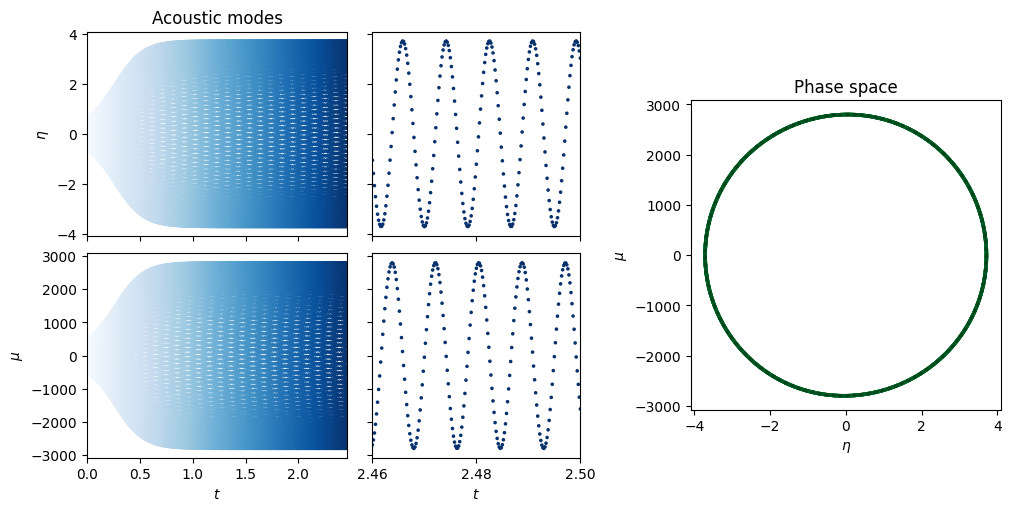

In [7]:

# Visualize model
fig1 = plt.figure(figsize=(10, 5), layout="constrained")
sub_fig1 = fig1.subfigures(1, 2, width_ratios=[1.5, 1])
axs = sub_fig1[0].subplots(2, 2, sharex='col', sharey='row', width_ratios=[1, 0.8])
Nt_zoom = int(true_case.t_CR / true_case.dt)
xlims = [[true_case.hist_t[0], true_case.hist_t[-1]-true_case.t_CR], [true_case.hist_t[-1]-true_case.t_CR, true_case.hist_t[-1]]]
for axs_, xl, tl in zip([axs[:, 0], axs[:, 1]], xlims, ['Acoustic modes', '']):
    for ii, ax, lbl in zip([0, 1], axs_, true_case.state_labels):
        ax.scatter(true_case.hist_t, true_case.hist[:, ii], c=true_case.hist_t, cmap='Blues', s=10, marker='.')
        if xl == xlims[0]:
            ax.set(ylabel=lbl)
    axs_[-1].set(xlabel='$t$', xlim=xl)
    axs_[0].set_title(tl)
ax = sub_fig1[1].subplots(1, 1)
ax.set_title('Phase space')
Nt_transient = int(true_case.t_transient // true_case.dt)
ax.scatter(true_case.hist[-Nt_transient:, 0], true_case.hist[-Nt_transient:, 1], c=true_case.hist_t[-Nt_transient:], cmap='Greens', s=10, marker='.')
ax.set(xlabel=true_case.state_labels[0], ylabel=true_case.state_labels[1])
ax.set_aspect(1. / ax.get_data_ratio())


### 2) Sample observations from the truth

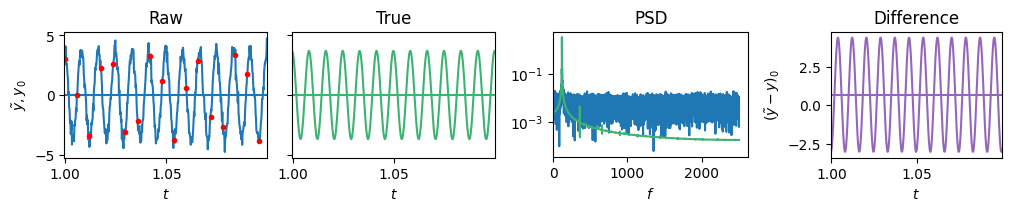

In [8]:
from essentials.create import create_noisy_signal

# Retrieve observables
d_true = true_case.get_observable_hist()
t_true = true_case.hist_t

std_obs = 0.1
d_raw = create_noisy_signal(d_true, noise_level=std_obs, noise_type='gaussian, additive')

# Draw data points from raw data
Nt_obs = 30 # time steps between analyses
t_start, t_stop = 1., 1.5 # start and end of assimilation

obs_idx = np.arange(t_start // dt_t, t_stop // dt_t + Nt_obs, Nt_obs, dtype=int)
d_obs, t_obs = d_raw[obs_idx], t_true[obs_idx]


# Visualize the truth and observations
from essentials.plotResults import plot_truth

truth = dict(model=VdP, y_raw=d_raw, y_true=d_true, t=t_true, dt=dt_t, y_obs=d_obs, t_obs=t_obs)
plot_truth(**truth, window=.1)

### 3) Create forecast ensemble

In [9]:
from essentials.create import create_ensemble


forecast_params = dict(model=VdP,      
                       dt=dt_t,             
                       m=50,               # Number of ensemble members
                       std_psi=0.8,        # Initial uncertainty in the state
                       Nq = 1,
                       # psi0=np.array([2.5, 2000.])
                       )

ensemble = create_ensemble(**forecast_params)


### 3) Apply data assimilation

In [10]:

rng = np.random.default_rng(0)

filter_ens = ensemble.copy()


# Define measurement error covariance matrix
std_d = 0.1 * np.max(abs(np.mean(filter_ens.get_observable_hist(), axis=-1)), axis=0)  

Cdd = np.diag(std_d ** 2)


# M = np.array([[1, 0], 
#               [0, 1]]) # Define measurement operator
M = np.array([[1, 0]]) # Define measurement operator

# ----------------------------------------------------------------------------
for d, t_d in zip(d_obs, t_obs):
    # Parallel forecast to next observation
    Nt = int(np.round((t_d - filter_ens.get_current_time) / filter_ens.dt))
    
    psi, t = filter_ens.time_integrate(Nt)
    filter_ens.update_history(psi, t) 
    
    # Perform assimilation 
    Aa = EnKF(filter_ens.get_current_state, d, Cdd, M)  # Analysis step
    
    # Update the initial condition for the next forecast
    filter_ens.update_history(Aa, update_last_state=True)
    
# ----------------------------------------------------------------------------

filter_ens.close() # closes the parallel pools


In [11]:


#Forecast the ensemble further without assimilation
Nt_extra = int(filter_ens.t_CR / filter_ens.dt) 

psi, t = filter_ens.time_integrate(Nt_extra, averaged=False)
filter_ens.update_history(psi, t)


/Users/andreanovoa/anaconda3/envs/da-env/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


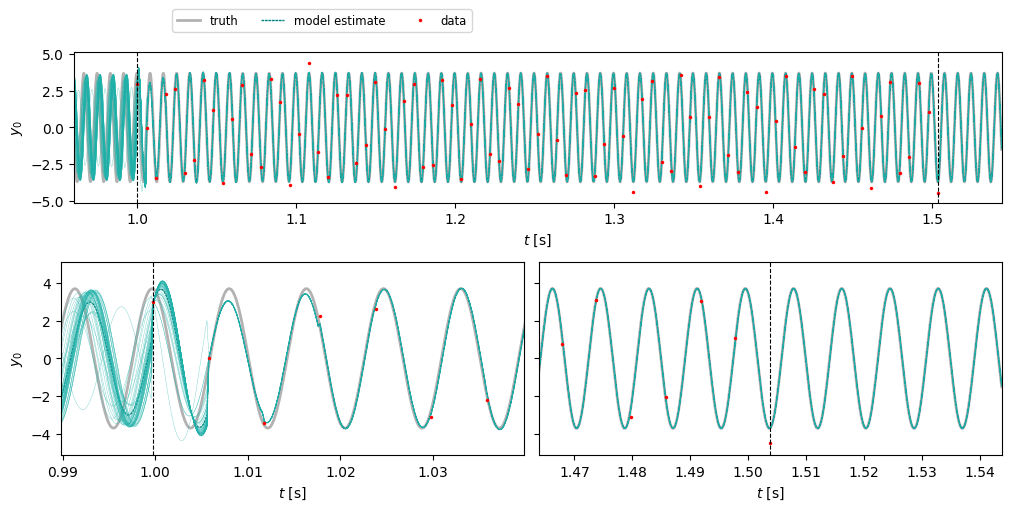

In [12]:
from essentials.plotResults import plot_timeseries
true_args = dict(y_raw=d_raw, 
                 y_true=d_true, 
                 t=t_true, 
                 dt=dt_t, 
                 t_obs=t_obs, 
                 y_obs=d_obs, 
                 dt_obs=Nt_obs * dt_t)

plot_timeseries(filter_ens, true_args, plot_ensemble_members=True)




<br />

___


### Exercises


<em> 
    
<font color=#7CB9E8> In practice, particularly for high-dimensional systems, only sparse or partial observations are available.  How does observing only one state affect the solution? 

</em>

___

Additionally, we rarely have perfect knowledge on the model parameters. See [tutorial 01](01_Augmented_formulation_VdP.ipynb) for combined state and parameter estimation.